In [ ]:
conda install -c bioconda trim-galore
https://github.com/FelixKrueger/TrimGalore/blob/master/Docs/Trim_Galore_User_Guide.md

trim_galore \
--illumina \
--paired \
--fastqc \
-o trim_galore/ \
CHK_AAAAOSDA_4_1_CC9G4ACXX.12BA001_clean.fastq.gz \
CHK_AAAAOSDA_4_2_CC9G4ACXX.12BA001_clean.fastq.gz

In [ ]:
https://github.com/ablab/spades
conda install -n anvio5 -c bioconda spades 

#!/bin/bash
#PBS -V # set verbose output
#PBS -N DASTool
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/SAGs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

source activate anvio5
for i in $(cat filenames.txt);
do cd $i;
spades.py --sc \
-1 *_1_* \
-2 *_2_* \
--threads 16 \
-o assembly;
cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/SAGs;
done

In [ ]:
for i in $(cat foldernames.txt);
do cd $i/assembly;
cp contigs.fasta ../../assembly/$i-contigs.fasta;
cd ../../;
done

ls -l | wc -l

In [ ]:
from Bio import SeqIO
import glob

file_list = glob.glob('*contigs.fasta')
for f in file_list:
	records_to_keep = [x for x in SeqIO.parse(f, 'fasta') if len(x.seq)>=10000]
	SeqIO.write(records_to_keep, f, 'fasta')

In [ ]:
from Bio import SeqIO
import glob
import os

file_list = glob.glob('*contigs.fasta')
for f in file_list:
    base_name = os.path.basename(f)
    new_filename = '%s.filtered.10k.fa' % base_name
    records_to_keep = [x for x in SeqIO.parse(f, 'fasta') if len(x.seq)>=10000]
    SeqIO.write(records_to_keep, new_filename, 'fasta')

In [ ]:
parallel anvi-script-reformat-fasta \
-o ./renamed/{1}.renamed.fa \
--simplify-names \
--prefix {1} \
-r ./renamed/{1}.mapping.txt {1}-contigs.fasta :::: names.txt

In [ ]:
#for VirSorter
cat *.renamed.fa > ../combined.renamed.10k.SAGs.fa

In [ ]:
anvi-script-reformat-fasta \
combined_SAGs_contigs.fa \
-o reformatted-combined-SAGs-contigs.fa \
-l 500 \
--simplify-names

In [ ]:
http://bowtie-bio.sourceforge.net/bowtie2/manual.shtml
    
#build bowtie index file named $SAMPLE_NAME
bowtie2-build all-sag-contigs.fa SAGs

#!/bin/bash
#PBS -V # set verbose output
#PBS -N sags-mappings
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/assembly/profiling
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l procs=32 # either this to specify number of processors.
#PBS -j oe
#PBS -l feature=highmem # High Memory

PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/assembly/profiling
OUT_DIR=$PROJECT_HOME/mappings
READS=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/shared_store/biller_reads

SAMPLE_NAME=SAGs

MAPPING_LOGFILE=$OUT_DIR/$SAMPLE_NAME.log

cd $PROJECT_HOME

for i in $(cat $PROJECT_HOME/filenames.txt); 
do source activate anvio5; 
bowtie2 --threads 32 -x $PROJECT_HOME/$SAMPLE_NAME -1 $READS/$i.fwd* -2 $READS/$i.rev* --no-unal -S $SAMPLE_NAME.$i.sam 2>&1 | tee -a $MAPPING_LOGFILE;

samtools view -F 4 -bS $SAMPLE_NAME.$i.sam > $SAMPLE_NAME.vs.$i.raw.bam;
samtools sort $SAMPLE_NAME.vs.$i.raw.bam -o $SAMPLE_NAME.vs.$i.sorted.bam;
samtools index $SAMPLE_NAME.vs.$i.sorted.bam;

source activate bamm;

bamm filter -b $SAMPLE_NAME.vs.$i.sorted.bam --percentage_id 0.95 2>&1 | tee -a $MAPPING_LOGFILE;

samtools sort -@ 32 -o $SAMPLE_NAME.vs.$i.sorted.95pc.bam $SAMPLE_NAME.vs.$i.sorted_filtered.bam;

samtools index $SAMPLE_NAME.vs.$i.sorted.95pc.bam;
mv $SAMPLE_NAME.vs.$i.sorted.95pc.bam* $OUT_DIR;

rm *$SAMPLE_NAME.vs.$i*;
rm *$SAMPLE_NAME.$i.sam;
done

In [ ]:
#checkM
#https://github.com/Ecogenomics/CheckM/wiki/Genome-Quality-Commands

PATH=$PATH:/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/Prodigal
source activate py27

checkm lineage_wf assemblies/ output/

cd SAGs/
checkm taxon_set order Rickettsiales Rickettsiales_markers
checkm analyze Rickettsiales_markers assembly/ output2 -x fasta -t 16
checkm qa --out_format 9 --file results_file.txt --tab_table -t 16 Rickettsiales_markers output2

checkm taxon_list | egrep "Pelagi*|Rickett*|SAR*|sar*|Sar*"
checkm taxon_set family Pelagibacteraceae Pelagibacteraceae_markers
checkm analyze Pelagibacteraceae_markers ./ checkm_output_pelagi -x fasta -t 16
checkm qa --out_format 2 --file checkm_output_pelagi/completeness_stats.txt --tab_table -t 16 Pelagibacteraceae_markers checkm_output_pelagi

In [ ]:
source activate bamm
bamm parse \
--coverages sags-coverage.tsv \
--coverage_mode tpmean \
--bamfiles *.bam \
--threads 16 \

In [ ]:
#output file needs to be transposed so grep can get each biller reads for bats, hots ...etc
#desktop

cd ~/projects/heatmaps/sags
rsync agb214@login.isca.ex.ac.uk:/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/assembly/profiling/mappings/sags-coverage.tsv .
python
import pandas as pd
df = pd.read_csv("sags-coverage.tsv", sep = "\t")
df #check import
df = df.transpose()
df #check transpose
df.to_csv("sags-coverage-transposed.tsv", sep = "\t")
*ctrl+d*

cat sags-coverage-transposed.tsv | egrep "contig|SRR5720219|SRR5720220|SRR5720221|SRR5720222|SRR5720223|SRR5720224|SRR5720225|SRR5720226|SRR5720227|SRR5720228|SRR5720239|SRR5720240|SRR5720241|SRR5720242|SRR5720243|SRR5720244|SRR5720245|SRR5720246|SRR5720247|SRR5720248|SRR5720265|SRR5720266|SRR5720267|SRR5720268|SRR5720269|SRR5720270|SRR5720271|SRR5720272|SRR5720273|SRR5720274|SRR5720287|SRR5720288|SRR5720289|SRR5720290|SRR5720291|SRR5720292|SRR5720293|SRR5720294|SRR5720295|SRR5720296|SRR5720297|SRR5720298|SRR5720299|SRR5720300|SRR5720301|SRR5720302|SRR5720303|SRR5720304|SRR5720305|SRR5720306|SRR5720308|SRR5720309|SRR5720310|SRR5720311|SRR5720312|SRR5720313|SRR5720314|SRR5720315|SRR5720316|SRR5720317|SRR5720324|SRR5720325|SRR5720328|SRR5720329|SRR5720330|SRR5720331|SRR6507277|SRR6507278" > sags-hots-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5720229|SRR5720230|SRR5720231|SRR5720232|SRR5720233|SRR5720234|SRR5720235|SRR5720236|SRR5720237|SRR5720238|SRR5720249|SRR5720250|SRR5720251|SRR5720252|SRR5720253|SRR5720254|SRR5720255|SRR5720256|SRR5720257|SRR5720258|SRR5720259|SRR5720260|SRR5720261|SRR5720262|SRR5720263|SRR5720264|SRR5720275|SRR5720276|SRR5720277|SRR5720278|SRR5720279|SRR5720280|SRR5720281|SRR5720282|SRR5720283|SRR5720284|SRR5720285|SRR5720286|SRR5720307|SRR5720318|SRR5720319|SRR5720320|SRR5720321|SRR5720322|SRR5720323|SRR5720326|SRR5720327|SRR5720332|SRR5720333|SRR5720334|SRR5720335|SRR5720336|SRR5720337|SRR5720338|SRR5720339|SRR5720340|SRR5720341|SRR5720342|SRR5720343|SRR5720344|SRR6507279|SRR6507280" > sags-bats-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5787989|SRR5787990|SRR5787992|SRR5787999|SRR5788000|SRR5788002|SRR5788015|SRR5788016|SRR5788017|SRR5788018|SRR5788019|SRR5788020|SRR5788021|SRR5788022|SRR5788023|SRR5788024|SRR5788047|SRR5788048|SRR5788059|SRR5788060|SRR5788099|SRR5788100|SRR5788103|SRR5788104|SRR5788105|SRR5788106|SRR5788108|SRR5788109|SRR5788110|SRR5788111|SRR5788112|SRR5788113|SRR5788114|SRR5788115|SRR5788116|SRR5788117|SRR5788140|SRR5788144|SRR5788145|SRR5788146|SRR5788147|SRR5788180|SRR5788181|SRR5788182|SRR5788183|SRR5788184|SRR5788185|SRR5788186|SRR5788187|SRR5788188|SRR5788189|SRR5788190|SRR5788192|SRR5788193|SRR5788194|SRR5788195|SRR5788196|SRR5788197|SRR5788198|SRR5788199|SRR5788200|SRR5788201|SRR5788229|SRR5788230|SRR5788231|SRR5788232|SRR5788233|SRR5788234|SRR5788235|SRR5788236|SRR5788237|SRR5788238|SRR5788256|SRR5788281|SRR5788282|SRR5788283|SRR5788284|SRR5788285|SRR5788286|SRR5788287|SRR5788288|SRR5788289|SRR5788290|SRR5788345|SRR5788346|SRR5788347|SRR5788348|SRR5788349|SRR5788350|SRR5788351|SRR5788352|SRR5788353|SRR5788354|SRR5788365|SRR5788366|SRR5788367|SRR5788368|SRR5788369|SRR5788370|SRR5788371|SRR5788372|SRR5788373|SRR5788374|SRR5788375|SRR5788376|SRR5788377|SRR5788378|SRR5788379|SRR5788380|SRR5788381|SRR5788382|SRR5788383|SRR5788384|SRR5788387|SRR5788427|SRR5788428|SRR5788429|SRR5788430|SRR5788431|SRR5788432|SRR5788433|SRR5788434|SRR5788435|SRR5788436|SRR5788447|SRR5788467|SRR5788468" > sags-ga02-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5787993|SRR5787994|SRR5788005|SRR5788006|SRR5788007|SRR5788008|SRR5788009|SRR5788010|SRR5788011|SRR5788012|SRR5788013|SRR5788014|SRR5788025|SRR5788036|SRR5788061|SRR5788062|SRR5788063|SRR5788064|SRR5788065|SRR5788066|SRR5788067|SRR5788068|SRR5788069|SRR5788070|SRR5788081|SRR5788082|SRR5788083|SRR5788084|SRR5788085|SRR5788086|SRR5788087|SRR5788088|SRR5788089|SRR5788090|SRR5788107|SRR5788138|SRR5788139|SRR5788141|SRR5788142|SRR5788143|SRR5788168|SRR5788169|SRR5788172|SRR5788173|SRR5788174|SRR5788175|SRR5788204|SRR5788213|SRR5788214|SRR5788215|SRR5788216|SRR5788217|SRR5788218|SRR5788219|SRR5788220|SRR5788221|SRR5788222|SRR5788223|SRR5788224|SRR5788225|SRR5788226|SRR5788227|SRR5788228|SRR5788249|SRR5788250|SRR5788251|SRR5788252|SRR5788253|SRR5788254|SRR5788312|SRR5788313|SRR5788314|SRR5788315|SRR5788316|SRR5788317|SRR5788318|SRR5788319|SRR5788320|SRR5788321|SRR5788322|SRR5788323|SRR5788335|SRR5788336|SRR5788337|SRR5788338|SRR5788339|SRR5788340|SRR5788341|SRR5788342|SRR5788343|SRR5788344|SRR5788407|SRR5788408|SRR5788409|SRR5788410|SRR5788411|SRR5788412|SRR5788413|SRR5788414|SRR5788425|SRR5788426|SRR5788448|SRR5788449|SRR5788450|SRR5788451|SRR5788452|SRR5788453|SRR5788454|SRR5788455|SRR5788456|SRR5788463|SRR5788464|SRR5788465|SRR5788466" > sags-ga03-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5788026|SRR5788027|SRR5788028|SRR5788029|SRR5788030|SRR5788031|SRR5788032|SRR5788033|SRR5788034|SRR5788035|SRR5788071|SRR5788072|SRR5788073|SRR5788074|SRR5788075|SRR5788076|SRR5788077|SRR5788078|SRR5788079|SRR5788080|SRR5788130|SRR5788131|SRR5788136|SRR5788137|SRR5788202|SRR5788203|SRR5788205|SRR5788206|SRR5788207|SRR5788208|SRR5788209|SRR5788210|SRR5788211|SRR5788212|SRR5788302|SRR5788303|SRR5788304|SRR5788305|SRR5788306|SRR5788307|SRR5788308|SRR5788309|SRR5788310|SRR5788311|SRR5788437|SRR5788438|SRR5788439|SRR5788440|SRR5788441|SRR5788442|SRR5788443|SRR5788444|SRR5788445|SRR5788446" > sags-ga10-coverage.tsv
cat sags-coverage-transposed.tsv | egrep "contig|SRR5787991|SRR5787995|SRR5787996|SRR5787997|SRR5787998|SRR5788001|SRR5788003|SRR5788004|SRR5788037|SRR5788038|SRR5788039|SRR5788040|SRR5788041|SRR5788042|SRR5788043|SRR5788044|SRR5788045|SRR5788046|SRR5788049|SRR5788050|SRR5788051|SRR5788052|SRR5788053|SRR5788054|SRR5788055|SRR5788056|SRR5788057|SRR5788058|SRR5788091|SRR5788092|SRR5788093|SRR5788094|SRR5788095|SRR5788096|SRR5788097|SRR5788098|SRR5788101|SRR5788102|SRR5788118|SRR5788119|SRR5788120|SRR5788121|SRR5788122|SRR5788123|SRR5788124|SRR5788125|SRR5788126|SRR5788127|SRR5788128|SRR5788129|SRR5788132|SRR5788133|SRR5788134|SRR5788135|SRR5788148|SRR5788149|SRR5788150|SRR5788151|SRR5788152|SRR5788153|SRR5788154|SRR5788155|SRR5788156|SRR5788157|SRR5788158|SRR5788159|SRR5788160|SRR5788161|SRR5788162|SRR5788163|SRR5788164|SRR5788165|SRR5788166|SRR5788167|SRR5788170|SRR5788171|SRR5788176|SRR5788177|SRR5788178|SRR5788179|SRR5788191|SRR5788239|SRR5788240|SRR5788241|SRR5788242|SRR5788243|SRR5788244|SRR5788245|SRR5788246|SRR5788247|SRR5788248|SRR5788255|SRR5788257|SRR5788258|SRR5788259|SRR5788260|SRR5788261|SRR5788262|SRR5788263|SRR5788264|SRR5788265|SRR5788266|SRR5788267|SRR5788268|SRR5788269|SRR5788270|SRR5788271|SRR5788272|SRR5788273|SRR5788274|SRR5788275|SRR5788276|SRR5788277|SRR5788278|SRR5788279|SRR5788280|SRR5788291|SRR5788292|SRR5788293|SRR5788294|SRR5788295|SRR5788296|SRR5788297|SRR5788298|SRR5788299|SRR5788300|SRR5788301|SRR5788324|SRR5788325|SRR5788326|SRR5788327|SRR5788328|SRR5788329|SRR5788330|SRR5788331|SRR5788332|SRR5788333|SRR5788334|SRR5788355|SRR5788356|SRR5788357|SRR5788358|SRR5788359|SRR5788360|SRR5788361|SRR5788362|SRR5788363|SRR5788364|SRR5788385|SRR5788386|SRR5788388|SRR5788389|SRR5788390|SRR5788391|SRR5788392|SRR5788393|SRR5788394|SRR5788395|SRR5788396|SRR5788397|SRR5788398|SRR5788399|SRR5788400|SRR5788401|SRR5788402|SRR5788403|SRR5788404|SRR5788405|SRR5788406|SRR5788415|SRR5788416|SRR5788417|SRR5788418|SRR5788419|SRR5788420|SRR5788421|SRR5788422|SRR5788423|SRR5788424|SRR5788457|SRR5788458|SRR5788459|SRR5788460|SRR5788461|SRR5788462" > sags-ga13-coverage.tsv


cat Biller-data-metadata.tsv | egrep "contig|SRR5720219|SRR5720220|SRR5720221|SRR5720222|SRR5720223|SRR5720224|SRR5720225|SRR5720226|SRR5720227|SRR5720228|SRR5720239|SRR5720240|SRR5720241|SRR5720242|SRR5720243|SRR5720244|SRR5720245|SRR5720246|SRR5720247|SRR5720248|SRR5720265|SRR5720266|SRR5720267|SRR5720268|SRR5720269|SRR5720270|SRR5720271|SRR5720272|SRR5720273|SRR5720274|SRR5720287|SRR5720288|SRR5720289|SRR5720290|SRR5720291|SRR5720292|SRR5720293|SRR5720294|SRR5720295|SRR5720296|SRR5720297|SRR5720298|SRR5720299|SRR5720300|SRR5720301|SRR5720302|SRR5720303|SRR5720304|SRR5720305|SRR5720306|SRR5720308|SRR5720309|SRR5720310|SRR5720311|SRR5720312|SRR5720313|SRR5720314|SRR5720315|SRR5720316|SRR5720317|SRR5720324|SRR5720325|SRR5720328|SRR5720329|SRR5720330|SRR5720331|SRR6507277|SRR6507278" > biller_hots_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5720229|SRR5720230|SRR5720231|SRR5720232|SRR5720233|SRR5720234|SRR5720235|SRR5720236|SRR5720237|SRR5720238|SRR5720249|SRR5720250|SRR5720251|SRR5720252|SRR5720253|SRR5720254|SRR5720255|SRR5720256|SRR5720257|SRR5720258|SRR5720259|SRR5720260|SRR5720261|SRR5720262|SRR5720263|SRR5720264|SRR5720275|SRR5720276|SRR5720277|SRR5720278|SRR5720279|SRR5720280|SRR5720281|SRR5720282|SRR5720283|SRR5720284|SRR5720285|SRR5720286|SRR5720307|SRR5720318|SRR5720319|SRR5720320|SRR5720321|SRR5720322|SRR5720323|SRR5720326|SRR5720327|SRR5720332|SRR5720333|SRR5720334|SRR5720335|SRR5720336|SRR5720337|SRR5720338|SRR5720339|SRR5720340|SRR5720341|SRR5720342|SRR5720343|SRR5720344|SRR6507279|SRR6507280" > biller_bats_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5787989|SRR5787990|SRR5787992|SRR5787999|SRR5788000|SRR5788002|SRR5788015|SRR5788016|SRR5788017|SRR5788018|SRR5788019|SRR5788020|SRR5788021|SRR5788022|SRR5788023|SRR5788024|SRR5788047|SRR5788048|SRR5788059|SRR5788060|SRR5788099|SRR5788100|SRR5788103|SRR5788104|SRR5788105|SRR5788106|SRR5788108|SRR5788109|SRR5788110|SRR5788111|SRR5788112|SRR5788113|SRR5788114|SRR5788115|SRR5788116|SRR5788117|SRR5788140|SRR5788144|SRR5788145|SRR5788146|SRR5788147|SRR5788180|SRR5788181|SRR5788182|SRR5788183|SRR5788184|SRR5788185|SRR5788186|SRR5788187|SRR5788188|SRR5788189|SRR5788190|SRR5788192|SRR5788193|SRR5788194|SRR5788195|SRR5788196|SRR5788197|SRR5788198|SRR5788199|SRR5788200|SRR5788201|SRR5788229|SRR5788230|SRR5788231|SRR5788232|SRR5788233|SRR5788234|SRR5788235|SRR5788236|SRR5788237|SRR5788238|SRR5788256|SRR5788281|SRR5788282|SRR5788283|SRR5788284|SRR5788285|SRR5788286|SRR5788287|SRR5788288|SRR5788289|SRR5788290|SRR5788345|SRR5788346|SRR5788347|SRR5788348|SRR5788349|SRR5788350|SRR5788351|SRR5788352|SRR5788353|SRR5788354|SRR5788365|SRR5788366|SRR5788367|SRR5788368|SRR5788369|SRR5788370|SRR5788371|SRR5788372|SRR5788373|SRR5788374|SRR5788375|SRR5788376|SRR5788377|SRR5788378|SRR5788379|SRR5788380|SRR5788381|SRR5788382|SRR5788383|SRR5788384|SRR5788387|SRR5788427|SRR5788428|SRR5788429|SRR5788430|SRR5788431|SRR5788432|SRR5788433|SRR5788434|SRR5788435|SRR5788436|SRR5788447|SRR5788467|SRR5788468" > biller_ga02_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5787993|SRR5787994|SRR5788005|SRR5788006|SRR5788007|SRR5788008|SRR5788009|SRR5788010|SRR5788011|SRR5788012|SRR5788013|SRR5788014|SRR5788025|SRR5788036|SRR5788061|SRR5788062|SRR5788063|SRR5788064|SRR5788065|SRR5788066|SRR5788067|SRR5788068|SRR5788069|SRR5788070|SRR5788081|SRR5788082|SRR5788083|SRR5788084|SRR5788085|SRR5788086|SRR5788087|SRR5788088|SRR5788089|SRR5788090|SRR5788107|SRR5788138|SRR5788139|SRR5788141|SRR5788142|SRR5788143|SRR5788168|SRR5788169|SRR5788172|SRR5788173|SRR5788174|SRR5788175|SRR5788204|SRR5788213|SRR5788214|SRR5788215|SRR5788216|SRR5788217|SRR5788218|SRR5788219|SRR5788220|SRR5788221|SRR5788222|SRR5788223|SRR5788224|SRR5788225|SRR5788226|SRR5788227|SRR5788228|SRR5788249|SRR5788250|SRR5788251|SRR5788252|SRR5788253|SRR5788254|SRR5788312|SRR5788313|SRR5788314|SRR5788315|SRR5788316|SRR5788317|SRR5788318|SRR5788319|SRR5788320|SRR5788321|SRR5788322|SRR5788323|SRR5788335|SRR5788336|SRR5788337|SRR5788338|SRR5788339|SRR5788340|SRR5788341|SRR5788342|SRR5788343|SRR5788344|SRR5788407|SRR5788408|SRR5788409|SRR5788410|SRR5788411|SRR5788412|SRR5788413|SRR5788414|SRR5788425|SRR5788426|SRR5788448|SRR5788449|SRR5788450|SRR5788451|SRR5788452|SRR5788453|SRR5788454|SRR5788455|SRR5788456|SRR5788463|SRR5788464|SRR5788465|SRR5788466" > biller_ga03_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5788026|SRR5788027|SRR5788028|SRR5788029|SRR5788030|SRR5788031|SRR5788032|SRR5788033|SRR5788034|SRR5788035|SRR5788071|SRR5788072|SRR5788073|SRR5788074|SRR5788075|SRR5788076|SRR5788077|SRR5788078|SRR5788079|SRR5788080|SRR5788130|SRR5788131|SRR5788136|SRR5788137|SRR5788202|SRR5788203|SRR5788205|SRR5788206|SRR5788207|SRR5788208|SRR5788209|SRR5788210|SRR5788211|SRR5788212|SRR5788302|SRR5788303|SRR5788304|SRR5788305|SRR5788306|SRR5788307|SRR5788308|SRR5788309|SRR5788310|SRR5788311|SRR5788437|SRR5788438|SRR5788439|SRR5788440|SRR5788441|SRR5788442|SRR5788443|SRR5788444|SRR5788445|SRR5788446" > biller_ga10_metadata.tsv
cat Biller-data-metadata.tsv | egrep "contig|SRR5787991|SRR5787995|SRR5787996|SRR5787997|SRR5787998|SRR5788001|SRR5788003|SRR5788004|SRR5788037|SRR5788038|SRR5788039|SRR5788040|SRR5788041|SRR5788042|SRR5788043|SRR5788044|SRR5788045|SRR5788046|SRR5788049|SRR5788050|SRR5788051|SRR5788052|SRR5788053|SRR5788054|SRR5788055|SRR5788056|SRR5788057|SRR5788058|SRR5788091|SRR5788092|SRR5788093|SRR5788094|SRR5788095|SRR5788096|SRR5788097|SRR5788098|SRR5788101|SRR5788102|SRR5788118|SRR5788119|SRR5788120|SRR5788121|SRR5788122|SRR5788123|SRR5788124|SRR5788125|SRR5788126|SRR5788127|SRR5788128|SRR5788129|SRR5788132|SRR5788133|SRR5788134|SRR5788135|SRR5788148|SRR5788149|SRR5788150|SRR5788151|SRR5788152|SRR5788153|SRR5788154|SRR5788155|SRR5788156|SRR5788157|SRR5788158|SRR5788159|SRR5788160|SRR5788161|SRR5788162|SRR5788163|SRR5788164|SRR5788165|SRR5788166|SRR5788167|SRR5788170|SRR5788171|SRR5788176|SRR5788177|SRR5788178|SRR5788179|SRR5788191|SRR5788239|SRR5788240|SRR5788241|SRR5788242|SRR5788243|SRR5788244|SRR5788245|SRR5788246|SRR5788247|SRR5788248|SRR5788255|SRR5788257|SRR5788258|SRR5788259|SRR5788260|SRR5788261|SRR5788262|SRR5788263|SRR5788264|SRR5788265|SRR5788266|SRR5788267|SRR5788268|SRR5788269|SRR5788270|SRR5788271|SRR5788272|SRR5788273|SRR5788274|SRR5788275|SRR5788276|SRR5788277|SRR5788278|SRR5788279|SRR5788280|SRR5788291|SRR5788292|SRR5788293|SRR5788294|SRR5788295|SRR5788296|SRR5788297|SRR5788298|SRR5788299|SRR5788300|SRR5788301|SRR5788324|SRR5788325|SRR5788326|SRR5788327|SRR5788328|SRR5788329|SRR5788330|SRR5788331|SRR5788332|SRR5788333|SRR5788334|SRR5788355|SRR5788356|SRR5788357|SRR5788358|SRR5788359|SRR5788360|SRR5788361|SRR5788362|SRR5788363|SRR5788364|SRR5788385|SRR5788386|SRR5788388|SRR5788389|SRR5788390|SRR5788391|SRR5788392|SRR5788393|SRR5788394|SRR5788395|SRR5788396|SRR5788397|SRR5788398|SRR5788399|SRR5788400|SRR5788401|SRR5788402|SRR5788403|SRR5788404|SRR5788405|SRR5788406|SRR5788415|SRR5788416|SRR5788417|SRR5788418|SRR5788419|SRR5788420|SRR5788421|SRR5788422|SRR5788423|SRR5788424|SRR5788457|SRR5788458|SRR5788459|SRR5788460|SRR5788461|SRR5788462" > biller_ga13_metadata.tsv

#transform these all back into the non transposed form
python
import pandas as pd
df = pd.read_csv("sags-hots-coverage.tsv", sep = "\t")



In [ ]:
source activate anvio5

for i in $(cat contig-names.txt);
do anvi-script-reformat-fasta $i-contigs.fasta -o $i-contigs-renamed.fasta --simplify-names --prefix $i -r $i-mappings.txt;
done

for i in $(cat contig-names.txt);
do barrnap $i-contigs.fasta --kingdom bac --threads 16 --outseq $i-ribosomal.txt;
done

In [ ]:
cat *-ribosomal.txt | egrep "5S_rRNA|23S_rRNA" > all_ribsomal_RNA.txt
open in excel and sep by ">_-(),:"
statment =IF((D2=D3)AND(C2=C3))OR((D1=D2)AND(C1=C2)) provides TRUE if on same contig. Sort by TRUE after paste special

In [20]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

rf = pd.read_csv("/home/minion/projects/SAGs/5S_rRNA_sstart_send.csv")
list_len = len(rf)
for i in range(0, list_len):
    records = list(SeqIO.parse(rf.address[i], "fasta"))
    v_region = records[(rf.contig[i]-1)].seq[0:rf.send[i]]
    record = SeqRecord(v_region, rf.sag[i]+"_sstart_to_5S_region", "", "")
    SeqIO.write(record, "/home/minion/projects/SAGs/SAG_contigs/variable_regions/5s/"+rf.sag[i]+"-variable-region.fasta", "fasta")

In [21]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

rf = pd.read_csv("/home/minion/projects/SAGs/23S_rRNA_sstart_send.csv")
list_len = len(rf)
for i in range(0, list_len):
    records = list(SeqIO.parse(rf.address[i], "fasta"))
    v_region = records[(rf.contig[i]-1)].seq[rf.sstart[i]:99999999999]
    record = SeqRecord(v_region, rf.sag[i]+"_23S_region_to_send", "", "")
    SeqIO.write(record, "/home/minion/projects/SAGs/SAG_contigs/variable_regions/23s/"+rf.sag[i]+"-variable-region.fasta", "fasta")

In [22]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

rf = pd.read_csv("/home/minion/projects/SAGs/sag-variable-region.csv")
list_len = len(rf)
for i in range(0, list_len):
    records = list(SeqIO.parse(rf.address[i], "fasta"))
    v_region = records[(rf.contig[i]-1)].seq[rf.sstart[i]:rf.send[i]]
    record = SeqRecord(v_region, rf.sag[i]+"_23S_to_5S", "", "")
    SeqIO.write(record, "/home/minion/projects/SAGs/SAG_contigs/variable_regions/23s_5s/"+rf.sag[i]+"-variable-region.fasta", "fasta")

In [ ]:
#!/bin/bash
#PBS -V # set verbose output
#PBS -N sags-self-mappings
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l procs=32 # either this to specify number of processors.
#PBS -j oe
#PBS -l feature=highmem # High Memory

source activate anvio5
PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags
OUT_DIR=$PROJECT_HOME/self_mappings
SAMPLE_NAME=SAGs

for sag in $(cat sag_names.txt); do
READS=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/$sag;
MAPPING_LOGFILE=$OUT_DIR/$sag.log;
cd $READS;
bowtie2-build /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/assembly/renamed/$sag-contigs-renamed.fasta SAGs 2>&1 | tee -a $MAPPING_LOGFILE;
bowtie2 --threads 32 -x $SAMPLE_NAME -1 *_1_* -2 *_2_* --no-unal -S $SAMPLE_NAME.$sag.sam 2>&1 | tee -a $MAPPING_LOGFILE;

samtools view -F 4 -bS $SAMPLE_NAME.$sag.sam > $SAMPLE_NAME.vs.$sag.raw.bam;
samtools sort $SAMPLE_NAME.vs.$sag.raw.bam -o $SAMPLE_NAME.vs.$sag.sorted.bam;
samtools index $SAMPLE_NAME.vs.$sag.sorted.bam;

mv $SAMPLE_NAME.vs.$sag.sorted.bam* $OUT_DIR;
rm *$SAMPLE_NAME*;
cd $PROJECT_HOME;
done

In [ ]:
source activate anvio5
for i in $(cat 23s-vr-5s-contigs.txt); do
coverageBed -d -a 23s-vr-5s.bed -b ../*$i.sorted.bam | grep "$i" > $i-23s-vr-5s-coverage.tsv;
done

source activate anvio5
for i in $(cat vr-5s-contigs.txt); do
coverageBed -d -a vr-5s.bed -b ../*$i.sorted.bam | grep "$i" > $i-vr-5s-coverage.tsv;
done

source activate anvio5
for i in $(cat 23s-vr-contigs.txt); do
coverageBed -d -a 23s-vr.bed -b ../*$i.sorted.bam | grep "$i" > $i-23s-vr-coverage.tsv;
done

In [299]:
import pandas as pd
import numpy as np
import glob

variance = []
path = "/home/minion/projects/SAGs/coverage/23s_5s/AA*.tsv"
for filename in glob.glob(path):
    df = pd.read_csv(filename, sep="\t", 
                     names=['contig', 'sstart', 'send', 'count', 'coverage'])
    df = df[df.coverage !=0]
    data = pd.DataFrame([df.contig[0], df.loc[:,"coverage"].var(), len(df)])
    variance.append(data)
variance = pd.concat(variance, axis=1)
variance = variance.transpose()
print(variance)
#variance.to_csv("/home/minion/projects/SAGs/abc.tsv", sep="\t", header = None, index = False)

                   0        1      2
0  AAEK_000000000002  7302.29  34116
0  AAJO_000000000001  127.092  49069
0  AAAY_000000000002  54052.9  23611
0  AAPZ_000000000001  386.792  45666
0  AAOA_000000000001  12298.1  52323
0  AADH_000000000002   129795  29983
0  AAIN_000000000005  6024.75  12814
0  AABC_000000000003  2097.83   2944
0  AAHL_000000000001  16151.9  33403
0  AAOI_000000000002  298.711  33180
0  AAET_000000000002  1404.44  13418
0  AABE_000000000001  972.025  41077
0  AAAU_000000000009  439.603   2939
0  AABL_000000000001  86.4188   2940
0  AAGM_000000000001  8599.28  42311
0  AAIZ_000000000002  24424.6  45343
0  AAHY_000000000005  1241.11  23470
0  AAPE_000000000002   374592  90206
0  AACI_000000000001  26266.2  52174
0  AANY_000000000002  3026.73  56468
0  AAFX_000000000001  2029.52  61945
0  AABZ_000000000002  7019.81  12535
0  AAHK_000000000002  4991.65  55433
0  AAPB_000000000002  12609.8  43614
0  AAHI_000000000001  793.596  56747
0  AAPR_000000000001  2349.87  51777
0

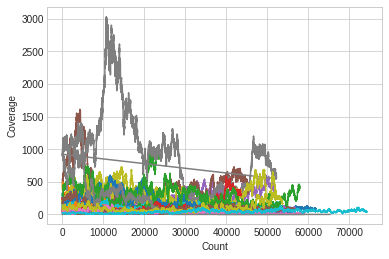

In [297]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

path = "/home/minion/projects/SAGs/coverage/23s_5s/*.tsv"
for filename in glob.glob(path):
    df = pd.read_csv(filename, sep="\t", 
                     names=['contig', 'sstart', 'send', 'count', 'coverage'])
    x = df["count"]
    y = df["coverage"].replace(np.nan, 0)
    plt.plot(x, y);
    plt.xlabel("Count")
    plt.ylabel("Coverage")

In [ ]:
#after barrnapp 
cat *.txt | egrep ">23S|>5S" > all-ribosomes.txt
# to get all the names of the ribosome locations into one file

In [191]:
import pandas as pd
df = pd.read_csv("/home/minion/Desktop/sags/all-ribosomes.txt", header = None)
df1 = df[0].str.split(">", expand = True)
df2 = df1[1].str.split(":", expand = True)
df3 = df2[3].str.split("-", n=1, expand = True)
df4 = df3[1].str.split(")", expand = True)
df5 = df4[0].str.split("(", expand = True)
df7 = df2[2].str.split("_", expand = True)

df6 = result.duplicated(subset="contig", keep=False)

df = pd.concat([df7[0], df2[0], df2[2], df3[0], df5, df6], axis=1, join="inner")
df.columns = ["genome","ribosome", "contig", "sstart", "send", "strand", "duplicate_contig"]

sags = pd.read_csv("/home/minion/Desktop/sags/sag_genome_addresses.csv", sep = '\t')
sags.set_index("genome", inplace = True)
df.set_index("genome", inplace = True)
abc=df.join(sags)
abc

,ribosome,contig,sstart,send,strand,duplicate_contig,address
genome,,,,,,,
AAAB,23S_rRNA,AAAB_000000000002,15073,17823,+,False,/home/minion/projects/SAGs/SAG_contigs/AAAB-co...
AAAC,23S_rRNA,AAAC_000000000013,10207,12940,-,True,/home/minion/projects/SAGs/SAG_contigs/AAAC-co...
AAAC,5S_rRNA,AAAC_000000000013,10001,10111,-,True,/home/minion/projects/SAGs/SAG_contigs/AAAC-co...
AAAE,23S_rRNA,AAAE_000000000002,11667,14416,-,False,/home/minion/projects/SAGs/SAG_contigs/AAAE-co...
AAAE,5S_rRNA,AAAE_000000000015,8014,8124,-,False,/home/minion/projects/SAGs/SAG_contigs/AAAE-co...
AAAF,23S_rRNA,AAAF_000000000007,8088,10837,-,False,/home/minion/projects/SAGs/SAG_contigs/AAAF-co...
AAAF,5S_rRNA,AAAF_000000000006,25371,25480,-,False,/home/minion/projects/SAGs/SAG_contigs/AAAF-co...
AAAG,23S_rRNA,AAAG_000000000033,5,1520,-,False,/home/minion/projects/SAGs/SAG_contigs/AAAG-co...
AAAG,23S_rRNA,AAAG_000000000050,847,1879,-,False,/home/minion/projects/SAGs/SAG_contigs/AAAG-co...


In [229]:
duplicate_true = abc.loc[abc.duplicate_contig==True]
duplicate_true.reset_index(drop=True, inplace=True)
duplicate_false = abc.loc[abc.duplicate_contig==False]
duplicate_false.reset_index(drop=True, inplace=True)

duplicate_false

int(duplicate_false.index)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'RangeIndex'

In [235]:
thisdict=duplicate_false.to_dict('index')
thisdict[3]


{'ribosome': '23S_rRNA',
 'contig': 'AAAF_000000000007',
 'sstart': '8088',
 'send': '10837',
 'strand': '-',
 'duplicate_contig': False,
 'address': '/home/minion/projects/SAGs/SAG_contigs/AAAF-contigs-renamed.fasta'}

In [256]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

for x, y in thisdict.items():
    if thisdict[x]['ribosome'] == '23S_rRNA':
        i = max(int(thisdict[x]['sstart']), int(thisdict[x]['send']))
        records = list(SeqIO.parse(thisdict[x]["address"], "fasta"))
        
        
        print(records)
        
#        record_dict = SeqIO.index(thisdict[x]["address"], "fasta")
#        sequences = record_dict[thisdict[x]["contig"].seq
#SeqIO.write(sequences, "example.fasta", "fasta")


[SeqRecord(seq=Seq('CATTTATCGCTATCTGAGATTTTTTAATAGTAAATTCCTTTTACAATTTTAGAA...TAT', SingleLetterAlphabet()), id='AAAB_000000000001', name='AAAB_000000000001', description='AAAB_000000000001', dbxrefs=[]), SeqRecord(seq=Seq('AATTGATTTTGCTATTGCTTCAGCTTGCCCCCTTTCATTCATAATTGGGACAAC...TTA', SingleLetterAlphabet()), id='AAAB_000000000002', name='AAAB_000000000002', description='AAAB_000000000002', dbxrefs=[]), SeqRecord(seq=Seq('TTGGATTAATGCTAATATTTTTATTTTTTACATATCAAATATTTAAAAAATTAT...AGA', SingleLetterAlphabet()), id='AAAB_000000000003', name='AAAB_000000000003', description='AAAB_000000000003', dbxrefs=[]), SeqRecord(seq=Seq('TAACAATAAACTGCTTTAATTTTTTTATAGTTTTTTGAAATATAGGTAGCGGTG...ACT', SingleLetterAlphabet()), id='AAAB_000000000004', name='AAAB_000000000004', description='AAAB_000000000004', dbxrefs=[]), SeqRecord(seq=Seq('TAATTAATCTATTGTCTTTAATTGAGGGATGAATTTTTGCTATTTTTCTTAAAT...TTA', SingleLetterAlphabet()), id='AAAB_000000000005', name='AAAB_000000000005', description='AAAB_000000000005

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

rf = pd.read_csv("/home/minion/projects/SAGs/sag-variable-region.csv")
list_len = len(rf)
for i in range(0, list_len):
    records = list(SeqIO.parse(rf.address[i], "fasta"))
    v_region = records[(rf.contig[i]-1)].seq[rf.sstart[i]:rf.send[i]]
    record = SeqRecord(v_region, rf.sag[i]+"_23S_to_5S", "", "")
    SeqIO.write(record, "/home/minion/projects/SAGs/SAG_contigs/variable_regions/23s_5s/"+rf.sag[i]+"-variable-region.fasta", "fasta")

In [ ]:
### VIRAL PORTION
prokka on cat 1,2,4,5 VIRSorter, prophage and viral separate

sag_virsorter_viral.fasta \
--outdir prokka_viral \
--prefix prokka_viral \
--force \
--kingdom Virus \
--compliant \
--evalue 10.0 \
--cpus 1 \
--genus sar11_viral \
--species \
--strain \
--locustag gene \
--addgenes \
--rfam

prokka_viral.tsv gives viral protein identity
prokka_viral.faa gives translated protein for each gene


#set up diamond previously done with sar202 project
wget ftp://ftp.ncbi.nlm.nih.gov/blast/db/FASTA/nr.gz
wget ftp://ftp.ncbi.nlm.nih.gov/pub/taxonomy/accession2taxid/prot.accession2taxid.gz
wget ftp://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdmp.zip

source activate anvio5
diamond makedb --in nr.gz --db nr --taxonmap prot.accession2taxid.gz --taxonnodes nodes.dmp

#run diamond blastx on the viral contigs to find identities
diamond blastx \
--db /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/diamond/nr.dmnd \
--query sag_virsorter_viral.fasta \
--out sag_viral_blastx.tsv \
--taxonmap /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/diamond/prot.accession2taxid.gz \
--taxonnodes /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/diamond/nodes.dmp \
--more-sensitive \
--outfmt 102 \
--threads 16 \
--block-size 20 
#--top 5 \
#--e 0.000001

In [ ]:
for i in *.fasta; \
do new_name=$(basename $i .reformatted.fasta); \
echo $new_name; \
wget --post-file="$i" "http://phaster.ca/phaster_api" -O phaster/${new_name}_phaster_output; \
sleep 10; \
done

In [ ]:
for i in $(cat job_ids.tsv); do
wget "http://phaster.ca/phaster_api?acc=$i";
sleep 10; 
done

In [ ]:
for i in *.fna; do mv $i $(basename $i .fna).fasta; done

In [ ]:
ln -s /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/other_sar11_genomes/*.fasta /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/reformatted
#!/bin/bash
#PBS -v # set verbose output
#PBS -N 
#PBS -d .
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -l vmem=128gb
#PBS -j oe
#PBS -M agb214@exeter.ac.uk
#PBS -m aesar11
#PBS -l feature=phi     # Phi

conda activate gtdbtk
gtdbtk classify_wf \
--genome_dir /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/reformatted \
--out_dir /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/sags/sar11_gtdbtk \
--extension fasta \
--prefix sar11 \
--cpus 16 2>&1 | tee sar11_gtdbtk.log

In [ ]:
#barrnap 16s seq for phylogenetics
for i in *.fasta; do barrnap $i --quiet --threads 8 -o $i.rrna.fa < $i > $i.rrna.gff; done
for i in *.fa; do cat $i | grep 16S -A 1 > $(basename $i .fasta.rrna.fa)_16s.fna; done
find . -name "*_16s.fna" -size 0 -print0 | xargs -0 rm # remove files with 0 size

In [ ]:
for i in *.fa; \
do prokka $i \
--outdir $(basename $i .fa) \
--prefix $(basename $i .fa) \
--force \
--kingdom Virus \
--compliant \
--addmrna \
--cpus 8 \
--genus $(basename $i .fa) \
--species \
--strain \
--locustag $(basename $i .fa)_gene \
--addgenes \
--rfam; \
done

In [ ]:
#split a fasta by record with BioPython
from Bio import SeqIO
import os
import glob
filename=glob.glob("*.fasta")
for f in filename:
    for record in SeqIO.parse(f, "fasta"):
        base_name=os.path.basename(f).split(".fasta")[0]
        SeqIO.write(record, base_name+record.description+".fna", "fasta")


In [ ]:
#renames a contig by its filename if it only contains 1 contig
from Bio import SeqIO
import os
import glob
filename=glob.glob("*.fasta")
for f in filename:
    for record in SeqIO.parse(f, "fasta"):
        base_name=os.path.basename(f).split(".fasta")[0]
        record.id=record.name=record.description=base_name
        SeqIO.write(record, record.id+".fna", "fasta")

In [ ]:
#converts a fastq into fasta
SeqIO.convert("s3_AE1712_C6_N1_7_80m.rev_val_2.fq", "fastq", "s3_AE1712_C6_N1_7_80m.rev_val_2.fasta", "fasta")

In [ ]:
conda activate py37
minimap2 -a all_phaster.fna all_virsorter.fna > alignments.sam
conda activate py27
samtools view -F 4 -bS alignments.sam > alignments.raw.bam
samtools sort alignments.raw.bam -o alignments.sorted.bam
samtools index alignments.sorted.bam
bamm filter -b alignments.sorted.bam --percentage_id 0.95
samtools sort alignments.sorted_filtered.bam -o alignments.sorted.95pc.bam
samtools index alignments.sorted.95pc.bam
rm alignments.raw.bam alignments.sam alignments.sorted.bam* alignments.sorted_filtered.bam*
bamm parse --coverages alignments-coverage.tsv --coverage_mode counts --bamfiles alignments.sorted.95pc.bam

In [ ]:
##viral tools tried
marvel --> glorified HMM + PROKKA
PHASTEST --> used. 
ViralPRO --> install via downloads and needs DLed subsequent libraries and software. Took hard.
VRprofile --> looking of virulence genes which may not be viral
PhiSpy --> broken script + no support in 20 years
Prophinder --> 2008 and old software
Metaphinder --> just a glorified blast
Virsorter --> used
VIRFinder --> haven't got it to work
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-76 ##read

In [62]:
import pandas as pd
AAAA = pd.read_csv("/home/minion/Desktop/all_sar11_viral_removed_bats_cmean_coverage.tsv", sep = "\t")
AAAA = AAAA.drop("Length", axis=1)
AAAA = df.rename(columns={"#contig":"contig"})
AAAA = df[df.contig.str.startswith("AAAA")].sum()
AAAA = pd.DataFrame(data=AAAA[0:]).T
AAAA["contig"] = "AAAA"
AAAA

,contig,scratch/mapping/all_sar11_viral_removed_SRR5720234.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720229.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720251.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720233.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720237.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720238.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720231.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720236.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720252.sorted.95pc.bam,...,scratch/mapping/all_sar11_viral_removed_SRR5720286.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720343.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720338.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720339.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720344.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720321.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720342.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720327.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR6507280.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR6507279.sorted.95pc.bam
0,AAAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
import pandas as pd
AAAB = pd.read_csv("/home/minion/Desktop/all_sar11_viral_removed_bats_cmean_coverage.tsv", sep = "\t")
AAAB = AAAB.drop("Length", axis=1)
AAAB = AAAB.rename(columns={"#contig":"contig"})
AAAB = AAAB[AAAB.contig.str.startswith("AAAB")].sum()
AAAB = pd.DataFrame(data=AAAB[0:]).T
AAAB["contig"] = "AAAB"
AAAB

,contig,scratch/mapping/all_sar11_viral_removed_SRR5720234.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720229.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720251.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720233.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720237.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720238.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720231.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720236.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720252.sorted.95pc.bam,...,scratch/mapping/all_sar11_viral_removed_SRR5720286.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720343.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720338.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720339.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720344.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720321.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720342.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR5720327.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR6507280.sorted.95pc.bam,scratch/mapping/all_sar11_viral_removed_SRR6507279.sorted.95pc.bam
0,AAAB,0.0443,0.1863,0.2778,0.4834,0.5321,0.6061,0.5058,0.3439,0.4579,...,0.3376,0.499,0.6494,0.6578,0.1979,0.3979,0.7869,1.0937,2.1754,3.087


In [180]:
all_data = []
all_data.append(AAAA)
all_data.append(AAAB)

In [200]:
import pandas as pd
import numpy as np
data = pd.read_csv("/home/minion/Desktop/all_sar11_viral_removed_bats_cmean_coverage.tsv", sep = "\t")
data = df.rename(columns={"#contig":"contig"})

all_data = []
for i in ["AAAA", "AAAB"]:
    data=data[data.contig.str.startswith(i)].sum()
    data["contig"]=i
    data=pd.DataFrame(data=data).T
    all_data.append(data)
#data
all_data
df = pd.DataFrame.from_items(all_data)
df

AttributeError: 'DataFrame' object has no attribute 'contig'